# prompt chain (functional api版本)

In [1]:
from langgraph.func import entrypoint, task
from langchain_community.chat_models.tongyi import ChatTongyi

llm = ChatTongyi( # type: ignore
    model="qwen3-1.7b",
    model_kwargs={
        "temperature": 0.0,
        "enable_thinking": False,
    },
)

In [2]:
# Tasks

# @task 装饰器：
# 告诉 LangGraph，这个函数是一个“节点”（Node）。
# 当这个函数在 @entrypoint 函数中被调用时，
# LangGraph 不会立即执行它，而是将其注册为图中的一个步骤。
@task
def generate_joke(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {topic}")
    return msg.content


def check_punchline(joke: str):
    """Gate function to check if the joke has a punchline"""
    # Simple check - does the joke contain "?" or "!"
    if "?" in joke or "!" in joke:
        return "Pass"

    return "Fail"


@task
def improve_joke(joke: str):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {joke}")
    return msg.content


@task
def polish_joke(joke: str):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {joke}")
    return msg.content


In [3]:
# @entrypoint 装饰器：
# 标记这个函数是整个工作流的“入口点”（Entrypoint）。
# 它类似于 StateGraph 中的 workflow.add_edge(START, "...")
@entrypoint()
def prompt_chaining_workflow(topic: str):
    original_joke = generate_joke(topic).result()
    if check_punchline(original_joke) == "Pass":
        return original_joke

    improved_joke = improve_joke(original_joke).result()
    return polish_joke(improved_joke).result()

In [4]:
# Invoke
for step in prompt_chaining_workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'generate_joke': "Why don't cats play football?  \nBecause they're too good at *pouncing*!"}


{'prompt_chaining_workflow': "Why don't cats play football?  \nBecause they're too good at *pouncing*!"}




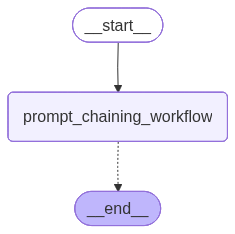

In [ ]:
from IPython.display import Image, display
# 这种方式只适用与简单的网络，并且流程图绘制的不对
png_bytes = prompt_chaining_workflow.get_graph().draw_mermaid_png()
display(Image(png_bytes))